In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Mounted at /content/drive


# BTC-USD

In [2]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/BTC-USD.csv',usecols=['Date','Close'],index_col='Date',parse_dates=True)

<Axes: xlabel='Date'>

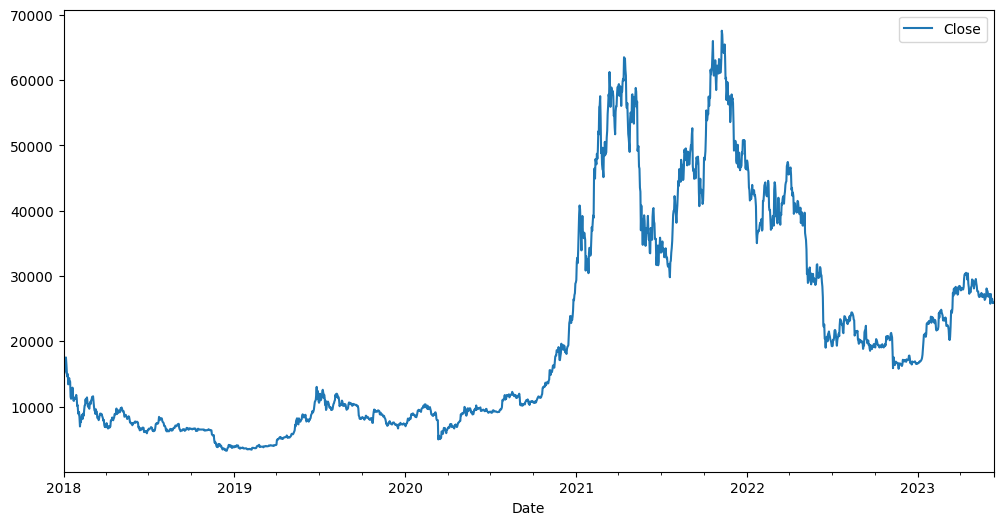

In [3]:
df.plot(figsize=(12,6))

In [4]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/BTC-USD.csv')
df1=df.reset_index()['Close']

In [5]:
len(df1)

1989

## 7:2:1

In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [8]:
test_size

397

In [9]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step - 1):
		a = dataset[i:(i + time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

em đã thử huấn luyện mô hình với time_step = 100 thế nhưng các chỉ số MAPE, MAE, RMSE quá cao. Do đó em tiến hành thử nghiệm vời time_step lần lượt tăng 10 giá trị

In [32]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [33]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [34]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 50ms/step - loss: 0.0151 - val_loss: 6.3234e-04
Epoch 2/100
21/21 [==============================] - 1s 38ms/step - loss: 7.4628e-04 - val_loss: 8.2699e-04
Epoch 3/100
21/21 [==============================] - 1s 35ms/step - loss: 5.7635e-04 - val_loss: 5.9662e-04
Epoch 4/100
21/21 [==============================] - 0s 19ms/step - loss: 4.8477e-04 - val_loss: 6.0740e-04
Epoch 5/100
21/21 [==============================] - 0s 20ms/step - loss: 5.0838e-04 - val_loss: 5.6036e-04
Epoch 6/100
21/21 [==============================] - 0s 19ms/step - loss: 4.5567e-04 - val_loss: 5.7344e-04
Epoch 7/100
21/21 [==============================] - 0s 19ms/step - loss: 4.4612e-04 - val_loss: 6.3110e-04
Epoch 8/100
21/21 [==============================] - 0s 20ms/step - loss: 4.2932e-04 - val_loss: 6.9704e-04
Epoch 9/100
21/21 [==============================] - 0s 20ms/step - loss: 4.1369e-04 - val_loss: 5.4199e-04
Epoch 10/100
21/21 [============

In [37]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 6ms/step


In [38]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [39]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs( (yval - y_pred_val) / yval )) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 7506920.849480946
MAE: 27761.443005019857
RMSE: 27851.758761416397
--------------------------
---------TEST----------
MAPE: 8501205.7387346
MAE: 28847.47327657924
RMSE: 30429.581607138305
-------------------


In [40]:
y_pred.shape

(296, 1)

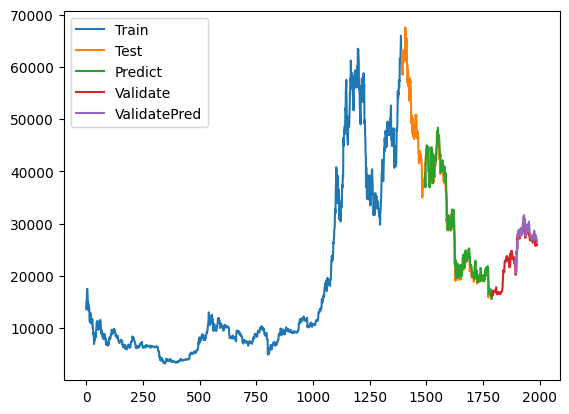

In [42]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [43]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [44]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [45]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [46]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(100, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [47]:
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [48]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 1s 45ms/step - loss: 0.0065 - val_loss: 0.3843
Epoch 2/100
14/14 [==============================] - 0s 31ms/step - loss: 6.5606e-04 - val_loss: 0.1236
Epoch 3/100
14/14 [==============================] - 0s 31ms/step - loss: 1.9128e-04 - val_loss: 0.0657
Epoch 4/100
14/14 [==============================] - 0s 30ms/step - loss: 1.4124e-04 - val_loss: 0.0571
Epoch 5/100
14/14 [==============================] - 0s 30ms/step - loss: 1.2098e-04 - val_loss: 0.0493
Epoch 6/100
14/14 [==============================] - 0s 31ms/step - loss: 1.2092e-04 - val_loss: 0.0457
Epoch 7/100
14/14 [==============================] - 0s 30ms/step - loss: 9.8954e-05 - val_loss: 0.0366
Epoch 8/100
14/14 [==============================] - 0s 31ms/step - loss: 9.9335e-05 - val_loss: 0.0338
Epoch 9/100
14/14 [==============================] - 0s 30ms/step - loss: 9.0208e-05 - val_loss: 0.0290
Epoch 10/100
14/14 [==============================] - 0s 31ms/step -

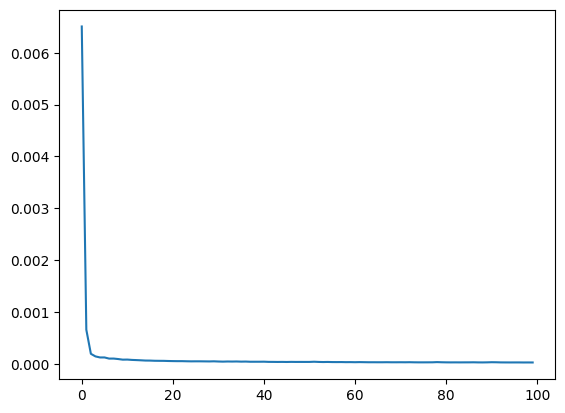

In [49]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [50]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 5ms/step


In [51]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

In [52]:
test_data.shape

(397, 1)

In [53]:
y_pred1.shape

(495, 1)

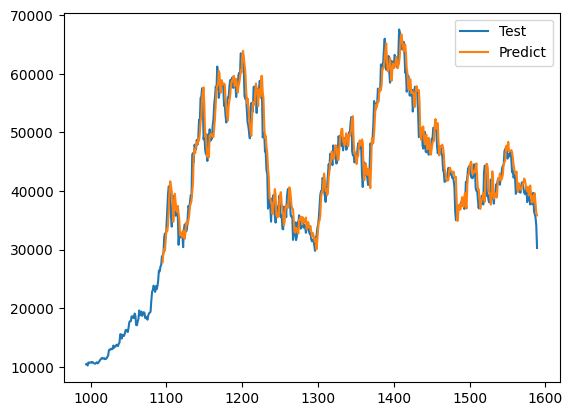

In [54]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [55]:
val_data1.shape

(399, 1)

In [56]:
y_pred_val1.shape

(298, 1)

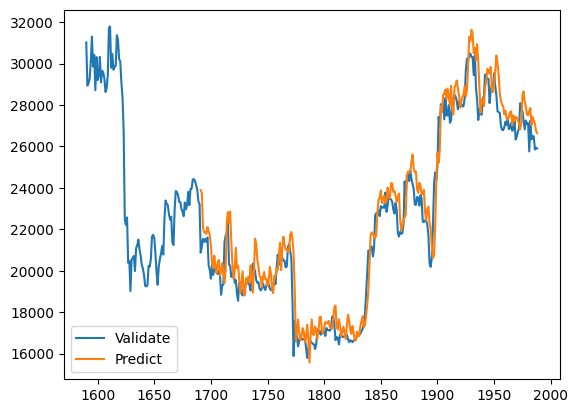

In [57]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [58]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 8088587.986892853
MAE: 22693.581241539414
RMSE: 23102.773155083403
--------------------------
---------TEST----------
MAPE: 7301018.7146712225
MAE: 46090.124295979374
RMSE: 46939.39728073821
-------------------


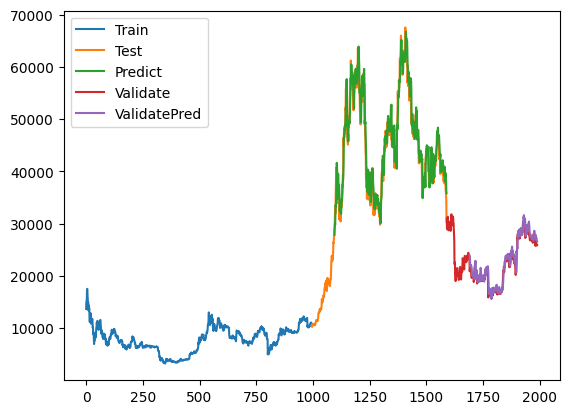

In [59]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# DOGE-USD

In [60]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/DOGE-USD.csv',usecols=['Date','Close'],index_col='Date',parse_dates=True)

In [61]:
df.head()

,Close
Date,
2018-01-01,0.008909
2018-01-02,0.009145
2018-01-03,0.009320
2018-01-04,0.009644
2018-01-05,0.012167


<Axes: xlabel='Date'>

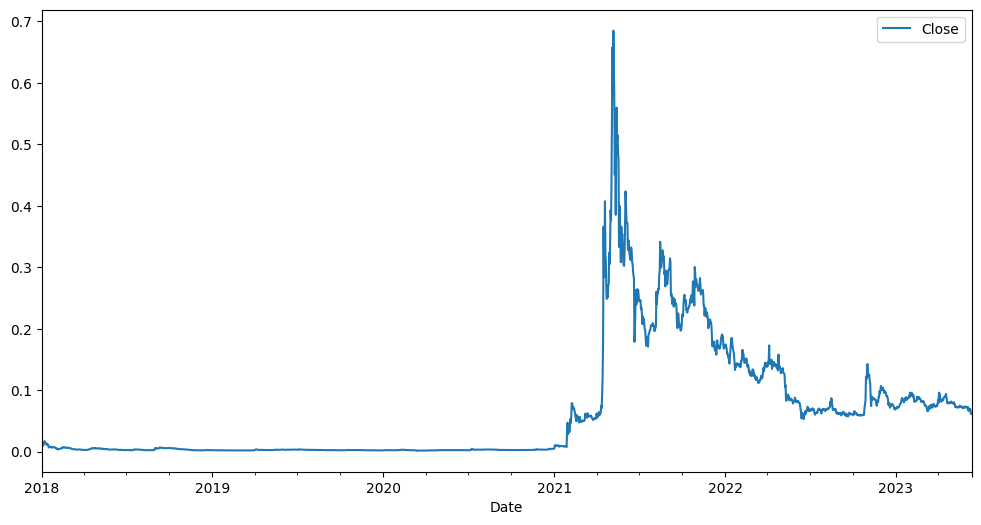

In [62]:
df.plot(figsize=(12,6))

In [63]:
df1 = df.reset_index()['Close']

In [64]:
len(df1)

1989

## 7:2:1

In [65]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [66]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [67]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [68]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [69]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [70]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(100, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 36ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 2/100
21/21 [==============================] - 1s 27ms/step - loss: 0.0013 - val_loss: 5.7779e-04
Epoch 3/100
21/21 [==============================] - 1s 36ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/100
21/21 [==============================] - 1s 49ms/step - loss: 9.2013e-04 - val_loss: 9.4568e-04
Epoch 5/100
21/21 [==============================] - 1s 48ms/step - loss: 7.5954e-04 - val_loss: 9.1423e-04
Epoch 6/100
21/21 [==============================] - 1s 49ms/step - loss: 6.7898e-04 - val_loss: 0.0013
Epoch 7/100
21/21 [==============================] - 1s 48ms/step - loss: 6.2843e-04 - val_loss: 4.0258e-04
Epoch 8/100
21/21 [==============================] - 1s 26ms/step - loss: 5.7001e-04 - val_loss: 5.2627e-04
Epoch 9/100
21/21 [==============================] - 1s 26ms/step - loss: 6.0674e-04 - val_loss: 3.1634e-04
Epoch 10/100
21/21 [==============================] 

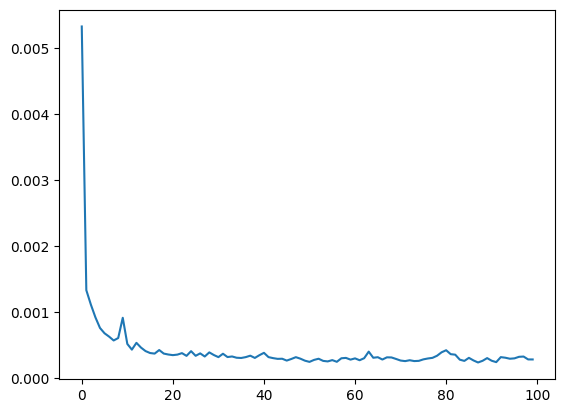

In [73]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [74]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 7ms/step


In [75]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

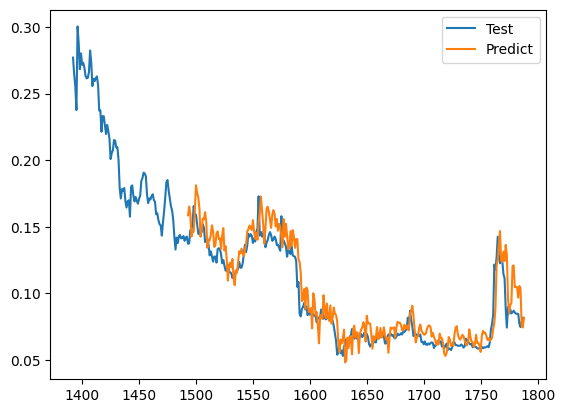

In [76]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

In [77]:
print(val_data.shape)
print(y_pred_val.shape)

(200, 1)
(99, 1)


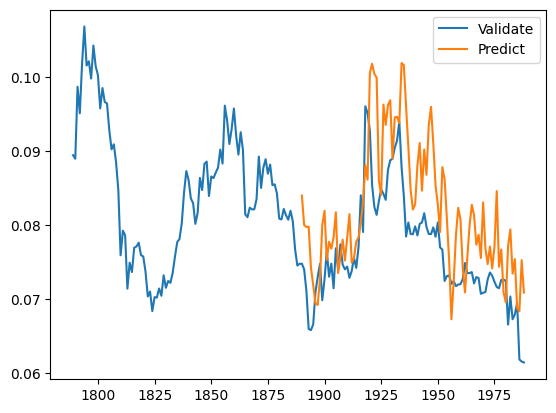

In [78]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','Predict'])
plt.show()

In [79]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 24.73311859042886
MAE: 0.02773946327237338
RMSE: 0.03065415948427802
--------------------------
---------TEST----------
MAPE: 39.00888450999941
MAE: 0.05573641318258845
RMSE: 0.06934014466352878
-------------------


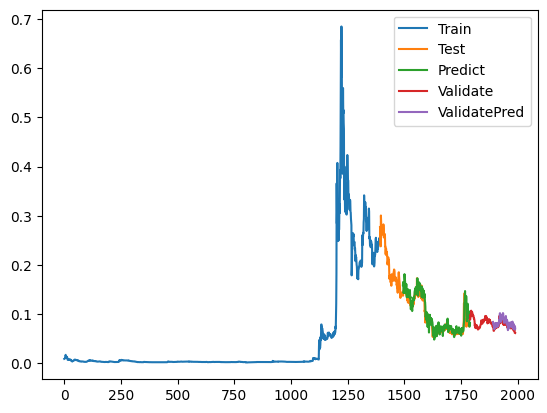

In [80]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [81]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [82]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [83]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [84]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(100, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [85]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [86]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 1s 43ms/step - loss: 1.9664e-04 - val_loss: 0.0329
Epoch 2/100
14/14 [==============================] - 0s 31ms/step - loss: 5.7840e-06 - val_loss: 0.0384
Epoch 3/100
14/14 [==============================] - 0s 29ms/step - loss: 1.9588e-06 - val_loss: 0.0420
Epoch 4/100
14/14 [==============================] - 0s 30ms/step - loss: 1.2047e-06 - val_loss: 0.0417
Epoch 5/100
14/14 [==============================] - 0s 30ms/step - loss: 1.0916e-06 - val_loss: 0.0400
Epoch 6/100
14/14 [==============================] - 0s 29ms/step - loss: 1.0003e-06 - val_loss: 0.0381
Epoch 7/100
14/14 [==============================] - 0s 30ms/step - loss: 9.1163e-07 - val_loss: 0.0360
Epoch 8/100
14/14 [==============================] - 0s 29ms/step - loss: 8.9103e-07 - val_loss: 0.0339
Epoch 9/100
14/14 [==============================] - 0s 29ms/step - loss: 8.4622e-07 - val_loss: 0.0320
Epoch 10/100
14/14 [==============================] - 0s 30ms/st

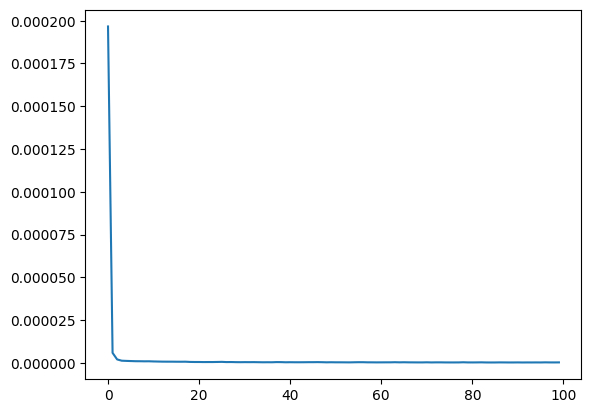

In [87]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [88]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 11ms/step


In [89]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

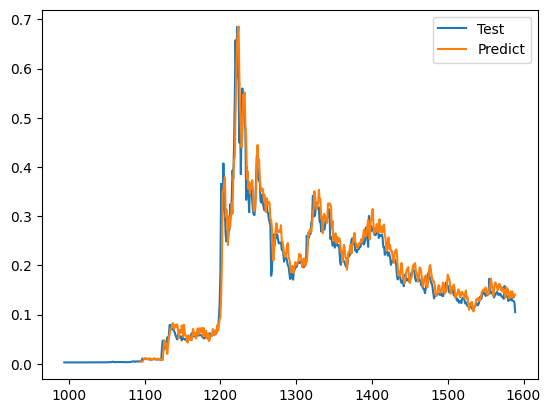

In [90]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [91]:
print(val_data1.shape)
print(y_pred_val1.shape)

(399, 1)
(298, 1)


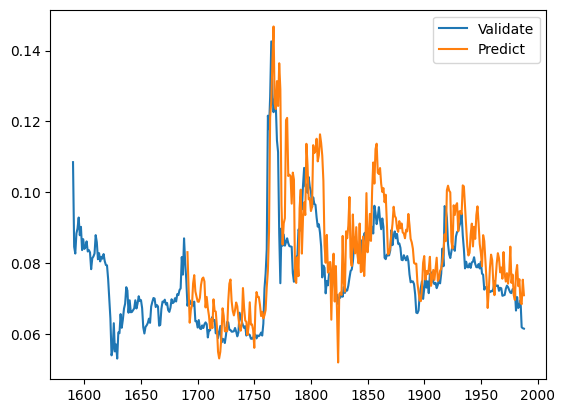

In [92]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [93]:
print('---------VALIDATE----------')

valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 26.404316908539393
MAE: 0.031352366828139674
RMSE: 0.03832115938492624
--------------------------
---------TEST----------
MAPE: 177.3017189559502
MAE: 0.16671737036071516
RMSE: 0.21570863162060877
-------------------


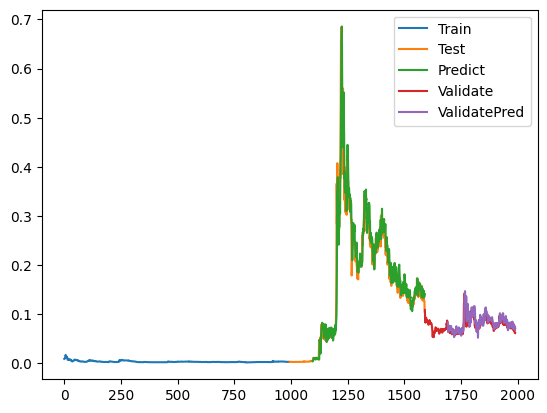

In [94]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

# ETH-USD

In [95]:
df = pd.read_csv('/content/drive/MyDrive/BA/Dataset/ETH-USD.csv',usecols=['Date','Close'],index_col='Date')

In [96]:
df

,Close
Date,
2018-01-01,772.640991
2018-01-02,884.443970
2018-01-03,962.719971
2018-01-04,980.921997
2018-01-05,997.719971
...,...
2023-06-08,1846.301880
2023-06-09,1840.225220
2023-06-10,1752.384766


<Axes: xlabel='Date'>

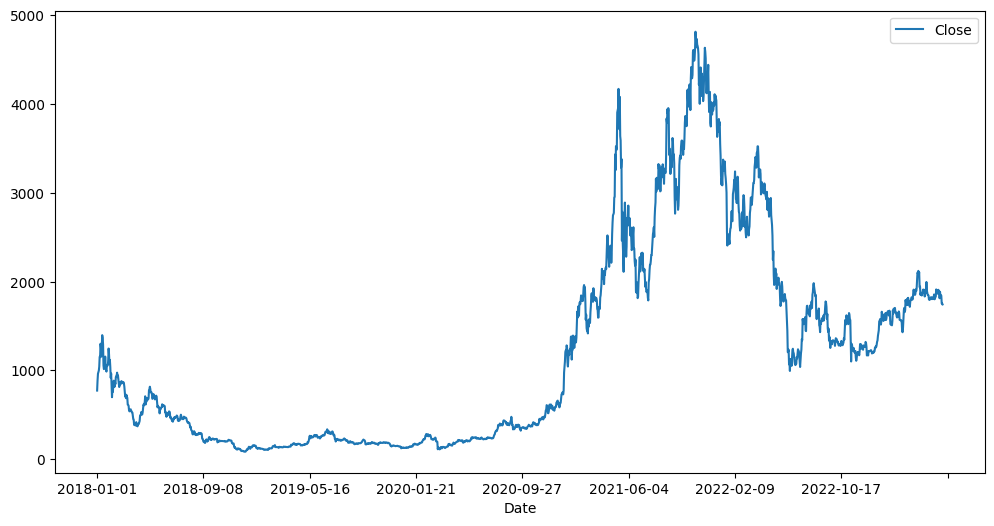

In [97]:
df.plot(figsize=(12,6))

In [98]:
df1 = df.reset_index()['Close']

In [99]:
df1

0        772.640991
1        884.443970
2        962.719971
3        980.921997
4        997.719971
           ...     
1984    1846.301880
1985    1840.225220
1986    1752.384766
1987    1753.415283
1988    1742.528687
Name: Close, Length: 1989, dtype: float64

In [100]:
len(df1)

1989

## 7:2:1

In [101]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [102]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size + test_size]
val_data = df1[train_size + test_size:]

In [103]:
import numpy
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [104]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [105]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

In [106]:
#Define LSTM Model
model = Sequential()
model.add(SimpleRNN(100, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [107]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [108]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 35ms/step - loss: 0.0073 - val_loss: 0.0031
Epoch 2/100
21/21 [==============================] - 1s 26ms/step - loss: 9.3455e-04 - val_loss: 0.0021
Epoch 3/100
21/21 [==============================] - 1s 26ms/step - loss: 7.2989e-04 - val_loss: 0.0012
Epoch 4/100
21/21 [==============================] - 1s 28ms/step - loss: 6.4869e-04 - val_loss: 0.0020
Epoch 5/100
21/21 [==============================] - 1s 26ms/step - loss: 5.6890e-04 - val_loss: 0.0021
Epoch 6/100
21/21 [==============================] - 1s 27ms/step - loss: 5.7374e-04 - val_loss: 9.6798e-04
Epoch 7/100
21/21 [==============================] - 1s 25ms/step - loss: 4.6115e-04 - val_loss: 8.3031e-04
Epoch 8/100
21/21 [==============================] - 1s 27ms/step - loss: 4.3078e-04 - val_loss: 8.1896e-04
Epoch 9/100
21/21 [==============================] - 1s 26ms/step - loss: 4.7078e-04 - val_loss: 0.0013
Epoch 10/100
21/21 [==============================] - 1s

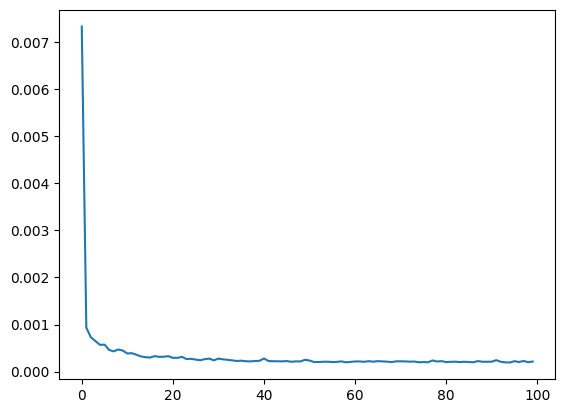

In [109]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [110]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

4/4 [==============================] - 0s 6ms/step


In [111]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

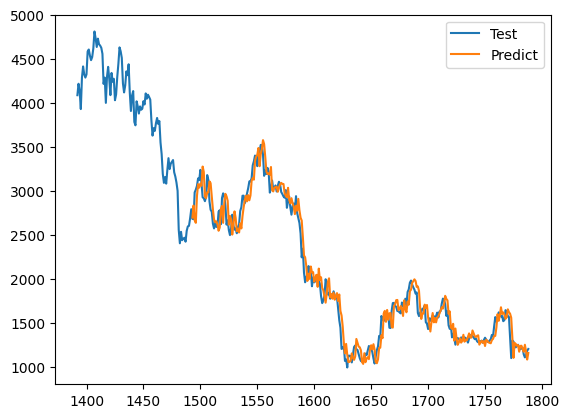

In [112]:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

plt.legend(['Test','Predict'])
plt.show()

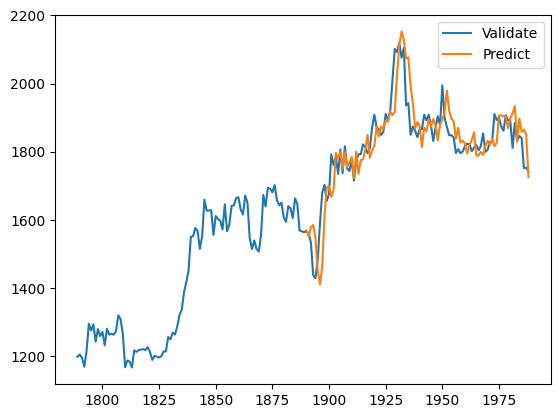

In [113]:
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Validate','Predict'])
plt.show()

In [114]:
print(val_data.shape)
print(y_pred_val.shape)

(200, 1)
(99, 1)


In [115]:
print('---------VALIDATE----------')

valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('MAPE:', valid_mape)

valid_mae = np.mean(np.abs(y_pred_val - yval))
print('MAE:', valid_mae)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
print('RMSE:', valid_rmse)

print('--------------------------')
print('---------TEST----------')

test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
print('MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('MAE:', test_mae)

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('RMSE:', test_rmse)

print('-------------------')

---------VALIDATE----------
MAPE: 499589.813461693
MAE: 1827.3771047532862
RMSE: 1831.9000987103216
--------------------------
---------TEST----------
MAPE: 571332.944389798
MAE: 1984.9779927588552
RMSE: 2113.394469886019
-------------------


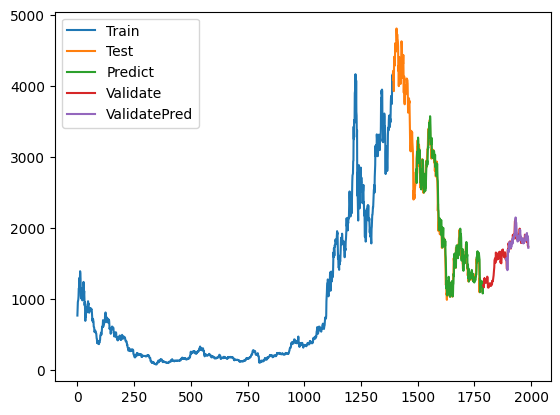

In [116]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()

## 5:3:2

In [117]:
train_size1 = int(0.5 * len(df1))
test_size1 = int(0.3 * len(df1))
val_size1 = len(df1) - train_size1 - test_size1

train_data1 = df1[:train_size1]
test_data1 = df1[train_size1:train_size1 + test_size1]
val_data1 = df1[train_size1 + test_size1:]

In [118]:
time_step = 100
X_train1, y_train1 = create_dataset(train_data1, time_step)
X_val1, yval1 = create_dataset(val_data1, time_step)
X_test1, ytest1 = create_dataset(test_data1, time_step)

In [119]:
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1], 1)
X_test1 = X_test1.reshape(X_test1.shape[0],X_test1.shape[1], 1)
X_val1 = X_val1.reshape(X_val1.shape[0],X_val1.shape[1], 1)

In [120]:
#Define LSTM Model
model1 = Sequential()
model1.add(SimpleRNN(100, input_shape=(time_step, 1)))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')

In [121]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [122]:
model1.fit(X_train1,y_train1,validation_data=(X_test1,ytest1),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 1s 50ms/step - loss: 0.0012 - val_loss: 0.1713
Epoch 2/100
14/14 [==============================] - 1s 54ms/step - loss: 1.9492e-04 - val_loss: 0.0856
Epoch 3/100
14/14 [==============================] - 1s 53ms/step - loss: 8.4139e-05 - val_loss: 0.0324
Epoch 4/100
14/14 [==============================] - 1s 56ms/step - loss: 4.4797e-05 - val_loss: 0.0155
Epoch 5/100
14/14 [==============================] - 1s 56ms/step - loss: 2.5884e-05 - val_loss: 0.0076
Epoch 6/100
14/14 [==============================] - 1s 56ms/step - loss: 2.2395e-05 - val_loss: 0.0051
Epoch 7/100
14/14 [==============================] - 1s 44ms/step - loss: 2.2914e-05 - val_loss: 0.0050
Epoch 8/100
14/14 [==============================] - 0s 30ms/step - loss: 2.2266e-05 - val_loss: 0.0047
Epoch 9/100
14/14 [==============================] - 0s 31ms/step - loss: 1.8904e-05 - val_loss: 0.0044
Epoch 10/100
14/14 [==============================] - 0s 30ms/step -

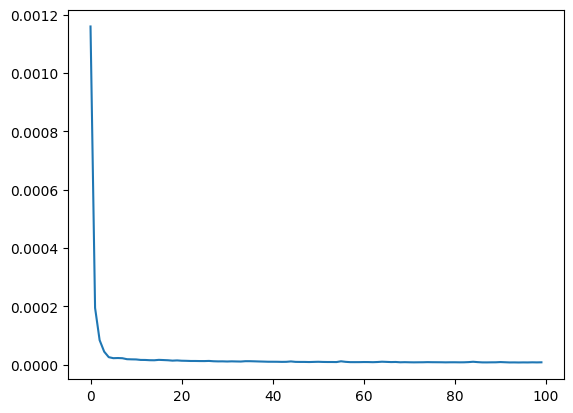

In [123]:
loss_per_epoch = model1.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [124]:
train_predict1 = model.predict(X_train1)
y_pred1 = model.predict(X_test1)
y_pred_val1 = model.predict(X_val1)

10/10 [==============================] - 0s 7ms/step


In [125]:
train_predict1 = scaler.inverse_transform(train_predict1)
y_pred1 = scaler.inverse_transform(y_pred1)
y_pred_val1 = scaler.inverse_transform(y_pred_val1)

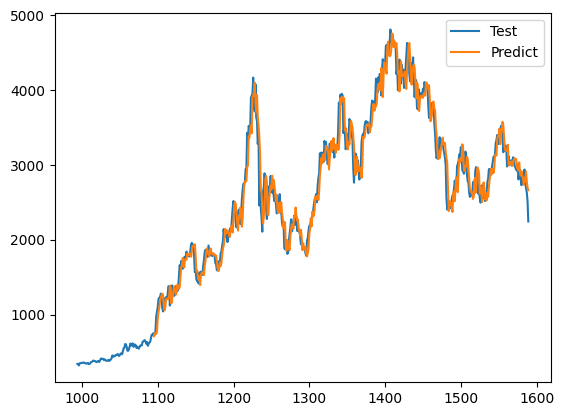

In [126]:
test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))

test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

plt.legend(['Test','Predict'])
plt.show()

In [127]:
print(val_data1.shape)
print(y_pred_val1.shape)

(399, 1)
(298, 1)


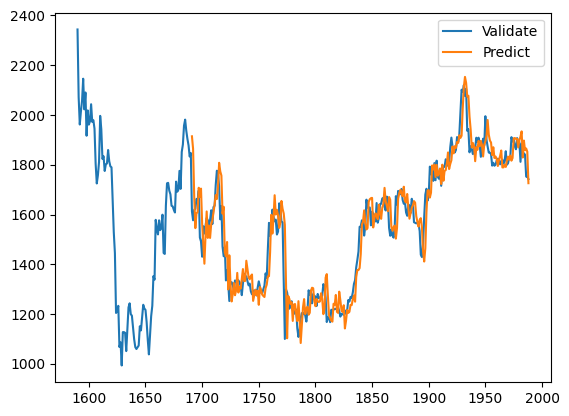

In [128]:
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Validate','Predict'])
plt.show()

In [129]:
ytest1.shape

(495,)

In [130]:
y_pred1.shape

(495, 1)

In [131]:
# Using the mean_absolute_percentage_error function
from sklearn.metrics import mean_absolute_percentage_error

error = mean_absolute_percentage_error(ytest1, y_pred1)
error

4887.61564116111

In [132]:
print('---------VALIDATE----------')

def mean_absolute_percentage_error(y_true, y_pred):
    common_length = min(len(y_true), len(y_pred))
    errors = np.abs(y_true[:common_length] - y_pred[:common_length]) / y_true[:common_length] * 100
    mape = np.mean(errors)
    return mape

valid_mape1 = mean_absolute_percentage_error(yval1,y_pred_val1)
# valid_mape1 = np.mean(np.abs((yval1 - y_pred_val1) / yval1)) * 100
print('MAPE:', valid_mape1)

valid_mae1 = np.mean(np.abs(y_pred_val1 - yval1))
print('MAE:', valid_mae1)

valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - yval1)**2))
print('RMSE:', valid_rmse1)

print('--------------------------')
print('---------TEST----------')

test_mape1 = np.mean(np.abs((ytest1 - y_pred1) / ytest1)) * 100
print('MAPE:', test_mape1)

test_mae1 = np.mean(np.abs(y_pred1 - ytest1))
print('MAE:', test_mae1)

test_rmse1 = np.sqrt(np.mean((y_pred1 - ytest1)**2))
print('RMSE:', test_rmse1)

print('-------------------')

---------VALIDATE----------
MAPE: 516623.8767676476
MAE: 1564.4415454154382
RMSE: 1584.602764085322
--------------------------
---------TEST----------
MAPE: 560595.0051494098
MAE: 2810.6602379029828
RMSE: 2951.6174719262285
-------------------


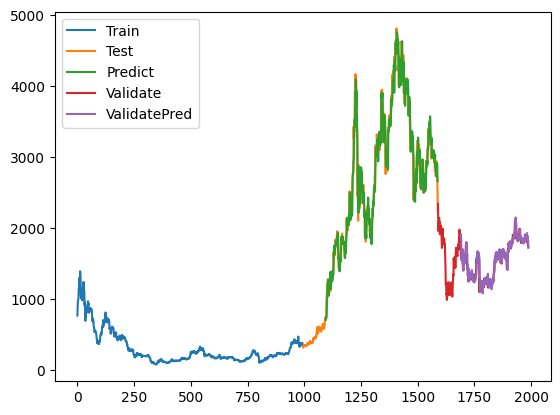

In [133]:
train_data_index1 = pd.RangeIndex(start=0, stop=train_size1, step=1)
plt.plot(scaler.inverse_transform(train_data1))

test_data_index1 = pd.RangeIndex(start=train_size1, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,scaler.inverse_transform(test_data1))
test_data_index1 = pd.RangeIndex(start=train_size1+101, stop=train_size1+test_size1, step=1)
plt.plot(test_data_index1,(y_pred1))

val_data_index1 = pd.RangeIndex(start=train_size1+test_size1, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,scaler.inverse_transform(val_data1))
val_data_index1 = pd.RangeIndex(start=train_size1+test_size1+101, stop=train_size1+test_size1+val_size1, step=1)
plt.plot(val_data_index1,y_pred_val1)

plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()